<a href="https://colab.research.google.com/github/amita-kapoor/COVID-2020/blob/master/Prediction_Covid_19_WorldWide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid 19 cases World Wide Analysis 
Data Source: https://github.com/CSSEGISandData/COVID-19

In [0]:
from datetime import timedelta, date
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2020, 1, 22)
end_dt = date(2020, 3, 14)
dates = []
for dt in daterange(start_dt, end_dt):
    dates.append(dt.strftime("%m-%d-%Y"))


In [0]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'
df1 = pd.read_csv(url+dates[0]+'.csv')
for date in tqdm(dates):
  #print(url+date+'.csv')
  df2 = pd.read_csv(url+date+'.csv')
  df1 = pd.merge(df1, df2, how='outer' )

100%|██████████| 53/53 [00:06<00:00,  7.81it/s]


In [0]:
df1.drop(['Province/State', 'Latitude', 'Longitude'], axis=1, inplace=True)
df1['Last Update']= pd.to_datetime(df1['Last Update']) 
df1['Last Update'] = df1['Last Update'].dt.date
df1.fillna(0, inplace = True)

In [0]:
df1.head()

,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,Mainland China,2020-01-22,1.0,0.0,0.0
1,Mainland China,2020-01-22,14.0,0.0,0.0
2,Mainland China,2020-01-22,6.0,0.0,0.0
3,Mainland China,2020-01-22,1.0,0.0,0.0
4,Mainland China,2020-01-22,0.0,0.0,0.0


In [0]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3589 entries, 0 to 3588
Data columns (total 5 columns):
Country/Region    3589 non-null object
Last Update       3589 non-null object
Confirmed         3589 non-null float64
Deaths            3589 non-null float64
Recovered         3589 non-null float64
dtypes: float64(3), object(2)
memory usage: 168.2+ KB


In [0]:
df1 = pd.pivot_table(df1, index=['Country/Region','Last Update'], aggfunc='sum')

In [0]:
df1.head(10)

Confirmed  Deaths  Recovered
Country/Region Last Update                              
 Azerbaijan    2020-02-28         1.0     0.0        0.0
Afghanistan    2020-02-24         1.0     0.0        0.0
               2020-03-08         4.0     0.0        0.0
               2020-03-10         5.0     0.0        0.0
               2020-03-11        14.0     0.0        0.0
               2020-03-14        11.0     0.0        0.0
Albania        2020-03-09         2.0     0.0        0.0
               2020-03-10        10.0     0.0        0.0
               2020-03-11        45.0     2.0        0.0
               2020-03-12        23.0     1.0        0.0

In [0]:
def plot_percent(df_country, Country):
  ## Plotting the percentage
  plt.rcParams.update({'font.size': 22})
  plt.rcParams["figure.figsize"] = [16,10]
  plt.rc('xtick',labelsize=14, )
  plt.rc('ytick',labelsize=14)
  ax = df_country.plot('Last Update', ['deceased_percent', 'recovered_percent'])
  #ax = df_country.plot('Last Update', 'deceased_percent')
  ax.set_ylabel("Percentage", fontname="Arial", fontsize=18)
  ax.set_xlabel("Date", fontname="Arial", fontsize=18)
  ax.legend(loc=0, prop={'size': 20})
  ax.set_title("Percentage deceased, recovered and severe in "+ Country, fontsize=20)
  plt.xticks(rotation=45)

In [0]:
def plot_total(df_country, Country):
  plt.rcParams.update({'font.size': 22})
  plt.rcParams["figure.figsize"] = [16,10]
  plt.rc('xtick',labelsize=14, )
  plt.rc('ytick',labelsize=14)
  df_country['Active'] = (df_country['Confirmed']- df_country['Deaths']-df_country['Recovered'])
  ax = df_country.plot('Last Update', ['Active', 'Recovered', 'Deaths'])
  ax.set_ylabel("Number", fontname="Arial", fontsize=18)
  ax.set_xlabel("Date", fontname="Arial", fontsize=18)
  ax.legend(loc=0, prop={'size': 20})
  ax.set_title("Active, Recovered and Deaths in  "+ Country, fontsize=20)
  plt.xticks(rotation=45)

In [0]:
from scipy.optimize import curve_fit
def prediction_country(Country, df1, plot_p = False, plot_t = False):
  df_final = df1.copy()
  df_country = df_final.loc[Country]
  df_country.reset_index(inplace=True)
  if Country == "Mainland China":
    df2 = df_final.loc['China']  ## Change in Nomenclature from 11th March 20202
    df2.reset_index(inplace=True)
    df_country.drop(df_country.tail(1).index,inplace=True)
    df_country = pd.merge(df_country, df2,how = 'outer')
    
  # Adding percentage of Deceased and ICU 

  df_country['deceased_percent'] = (df_country['Deaths']/ df_country['Confirmed'])*100
  df_country['recovered_percent'] = (df_country['Recovered']/ df_country['Confirmed'])*100

  if plot_p: plot_percent(df_country, Country)
  if plot_t: plot_total(df_country, Country)
  xdata=np.array(range(df_country.shape[0]))
  ydata=df_country['Confirmed'].values

  def func(x,a,b):
    return a*2**(x/b)
  popt, pcov = curve_fit(func,xdata=xdata,ydata=ydata)
  perr = np.sqrt(np.diag(pcov))
  resid = np.linalg.norm(ydata-func(xdata, *popt))
  print("For {} the coefficients of function is \n {} * 2 ** (t/{}) \n The covariance is:\n {} \n and the error is {}".format(Country,popt[0], popt[1], pcov, resid))


  fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
  perc = np.diff(ydata) / ydata[:-1]
  yfit = popt[0]*2**(xdata/popt[1])
  perc_fit = np.diff(yfit) / yfit[:-1]
  ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
  #ax1.set_yscale('log')
  ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
  ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
  ax1.legend(fontsize=15)
  plt.show()
  return [Country, df_country['Last Update'][0],df_country['Confirmed'].iloc[-1], df_country['deceased_percent'].iloc[-1], df_country['recovered_percent'].iloc[-1],popt[1]] 



In [0]:
Countries = ["Mainland China", "Italy", "Iran", "South Korea", "France", "Spain", "Germany", "UK", "US", "India"]

For Mainland China the coefficients of function is 
 23535.769690208366 * 2 ** (t/24.679912177679654) 
 The covariance is:
 [[8.90884235e+06 7.96819178e+03]
 [7.96819178e+03 7.92597522e+00]] 
 and the error is 121528.01307769955


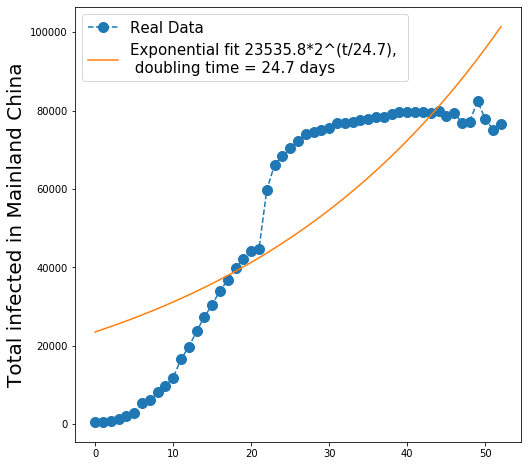

For Italy the coefficients of function is 
 55.356041160769024 * 2 ** (t/2.485141591256241) 
 The covariance is:
 [[2.11419339e+03 1.63511285e+01]
 [1.63511285e+01 1.27386525e-01]] 
 and the error is 12710.473272952855


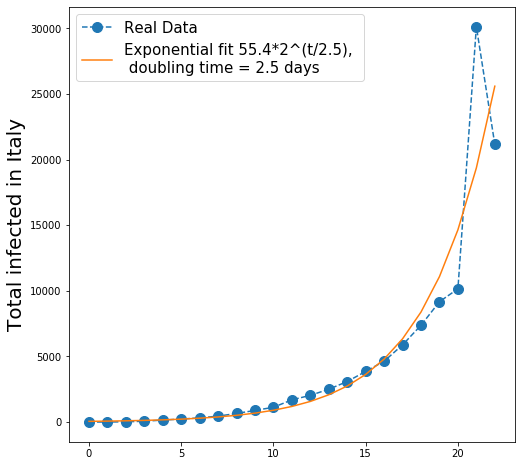

For Iran the coefficients of function is 
 204.65800735136406 * 2 ** (t/3.5236494731628176) 
 The covariance is:
 [[2.06907628e+04 8.94447151e+01]
 [8.94447151e+01 3.92812990e-01]] 
 and the error is 10955.055839196242


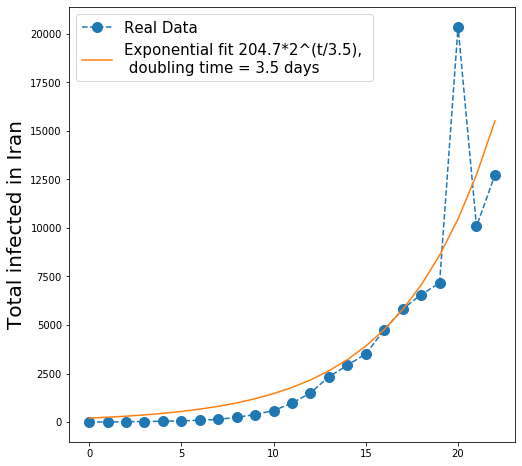

For South Korea the coefficients of function is 
 32.41162101922224 * 2 ** (t/5.179229353126951) 
 The covariance is:
 [[9.83301694e+01 3.00305602e+00]
 [3.00305602e+00 9.25615559e-02]] 
 and the error is 3461.024400773934


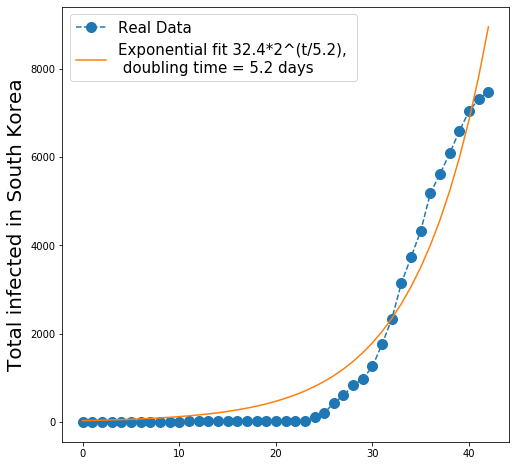

For France the coefficients of function is 
 0.22854066449152244 * 2 ** (t/1.9282395117736648) 
 The covariance is:
 [[0.09184866 0.07947801]
 [0.07947801 0.06894772]] 
 and the error is 2598.386844212736


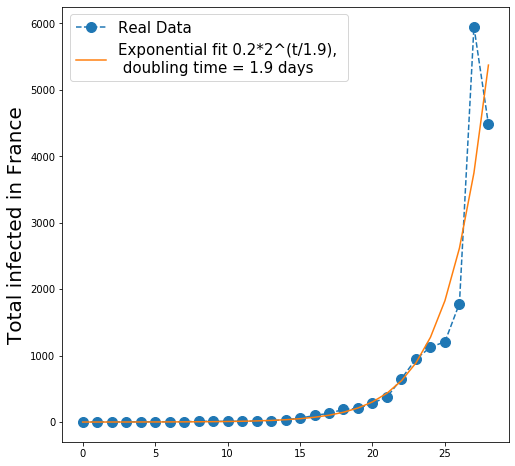

For Spain the coefficients of function is 
 9.260805194798982 * 2 ** (t/2.1250946625474074) 
 The covariance is:
 [[211.67893392   7.82051017]
 [  7.82051017   0.2907622 ]] 
 and the error is 4948.354991492159


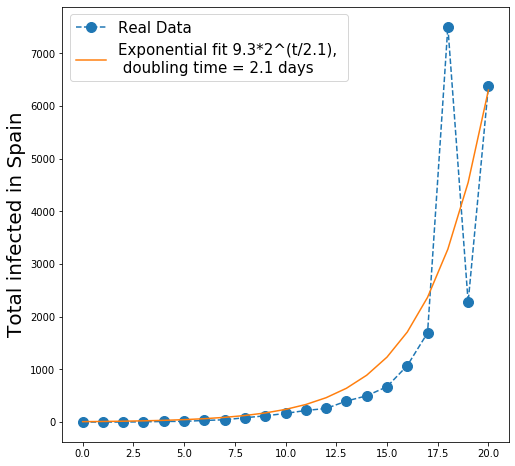

For Germany the coefficients of function is 
 1.5359048506504465 * 2 ** (t/2.59661634583823) 
 The covariance is:
 [[4.18093982 0.92262782]
 [0.92262782 0.20445447]] 
 and the error is 3325.8345728603717


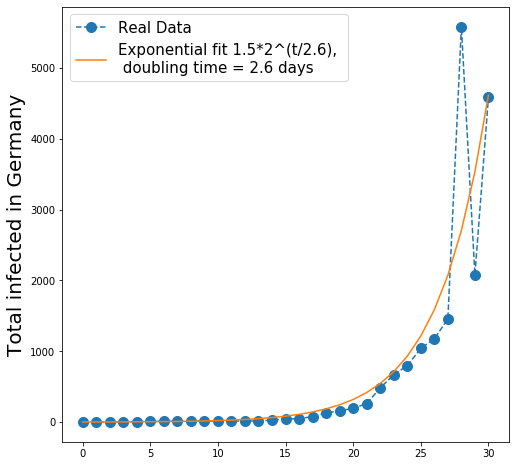

For UK the coefficients of function is 
 3.5593206244700153 * 2 ** (t/2.782135102460457) 
 The covariance is:
 [[0.34225649 0.06074187]
 [0.06074187 0.01091911]] 
 and the error is 50.827339162602314


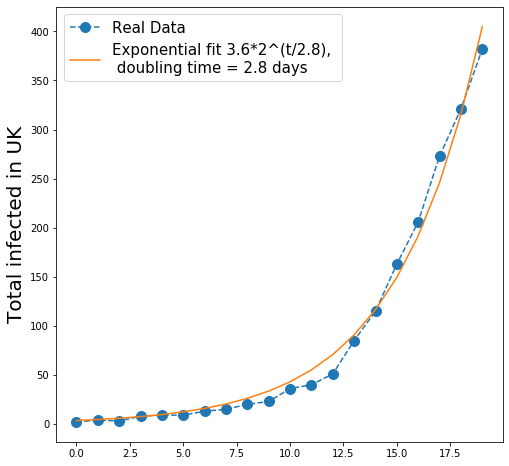

For US the coefficients of function is 
 0.6070430511667184 * 2 ** (t/3.1337611784367145) 
 The covariance is:
 [[1.66677371 1.10182152]
 [1.10182152 0.73131325]] 
 and the error is 2954.373286386072


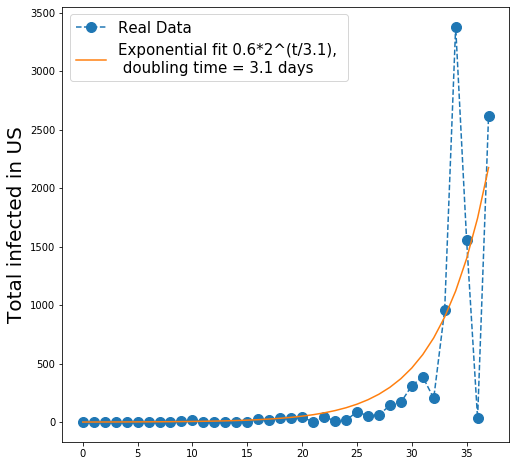

For India the coefficients of function is 
 4.978090177787439 * 2 ** (t/3.525008067586038) 
 The covariance is:
 [[7.62155226 1.90895519]
 [1.90895519 0.49293427]] 
 and the error is 75.4942826403627


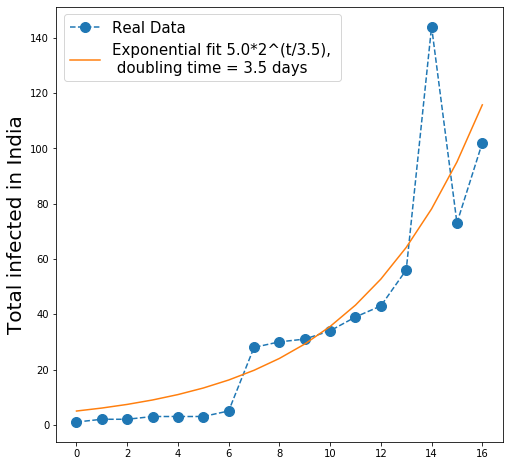

In [0]:
List = []
for Country in Countries:
  List.append(prediction_country(Country, df1))

In [0]:
df_summary = pd.DataFrame(List, columns = ["Country", "First Case", "Total Confirmed Today", "Deceased Percent", "Recovered Percent", "Doubling time in days"])

In [0]:
df_summary

,Country,First Case,Total Confirmed Today,Deceased Percent,Recovered Percent,Doubling time in days
0,Mainland China,2020-01-22,76600.0,4.126632,80.082245,24.679912
1,Italy,2020-01-31,21157.0,6.810985,9.292433,2.485142
2,Iran,2020-02-19,12729.0,4.800063,23.246131,3.523649
3,South Korea,2020-01-22,7478.0,0.708746,1.577962,5.179229
4,France,2020-01-24,4480.0,2.031250,0.267857,1.928240
5,Spain,2020-02-01,6391.0,3.051166,8.089501,2.125095
6,Germany,2020-01-28,4585.0,0.196292,1.003272,2.596616
7,UK,2020-01-31,382.0,1.570681,4.712042,2.782135
8,US,2020-01-22,2617.0,2.063431,0.458540,3.133761
9,India,2020-01-30,102.0,1.960784,3.921569,3.525008


In [0]:
Country = "Mainland China"
df_china = df1.loc[Country]
df_china.reset_index(inplace=True)
df_china.drop(df_china.tail(1).index,inplace=True)
if Country == "Mainland China":
    df2 = df1.loc['China']  ## Change in Nomenclature from 11th March 20202
    df2.reset_index(inplace=True)
    df_china.drop(df_china.tail(1).index,inplace=True)
    df_china = pd.merge(df_china, df2,how = 'outer')
df_china['active'] = (df_china['Confirmed']- df_china['Deaths']-df_china['Recovered'])
df_china['c-d'] = (df_china['Confirmed']- df_china['Deaths'])
df_china

,Last Update,Confirmed,Deaths,Recovered,active,c-d
0,2020-01-22,547.0,17.0,28.0,502.0,530.0
1,2020-01-23,639.0,18.0,30.0,591.0,621.0
2,2020-01-24,916.0,26.0,36.0,854.0,890.0
3,2020-01-25,1399.0,42.0,39.0,1318.0,1357.0
4,2020-01-26,2062.0,56.0,49.0,1957.0,2006.0
5,2020-01-27,2863.0,82.0,58.0,2723.0,2781.0
6,2020-01-28,5494.0,131.0,101.0,5262.0,5363.0
7,2020-01-29,6070.0,133.0,120.0,5817.0,5937.0
8,2020-01-30,8124.0,171.0,135.0,7818.0,7953.0
9,2020-01-31,9812.0,213.0,216.0,9383.0,9599.0


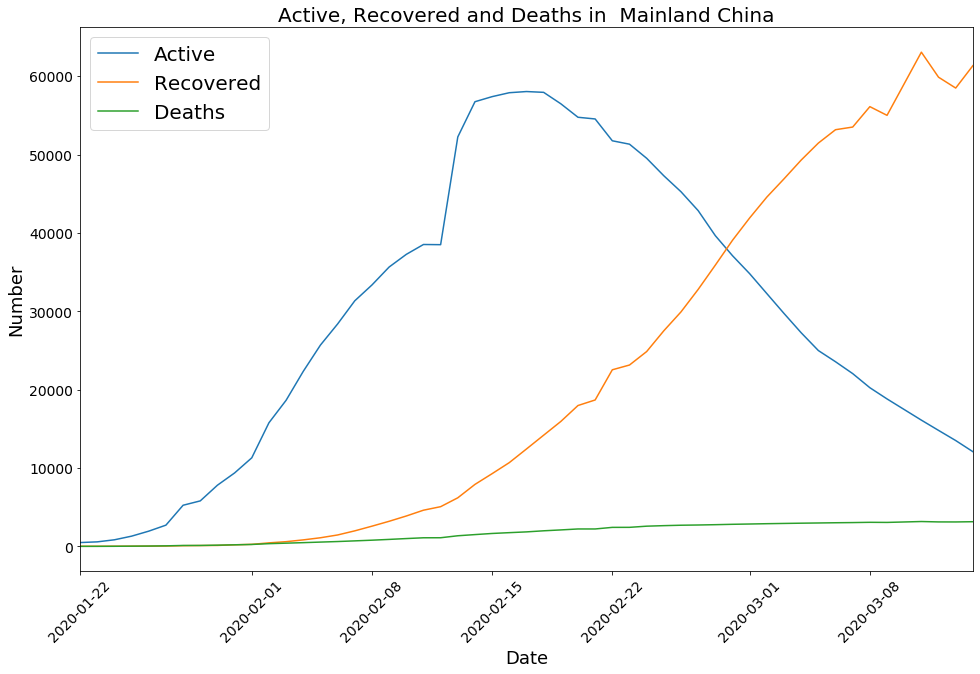

In [0]:
plot_total(df_china,Country)

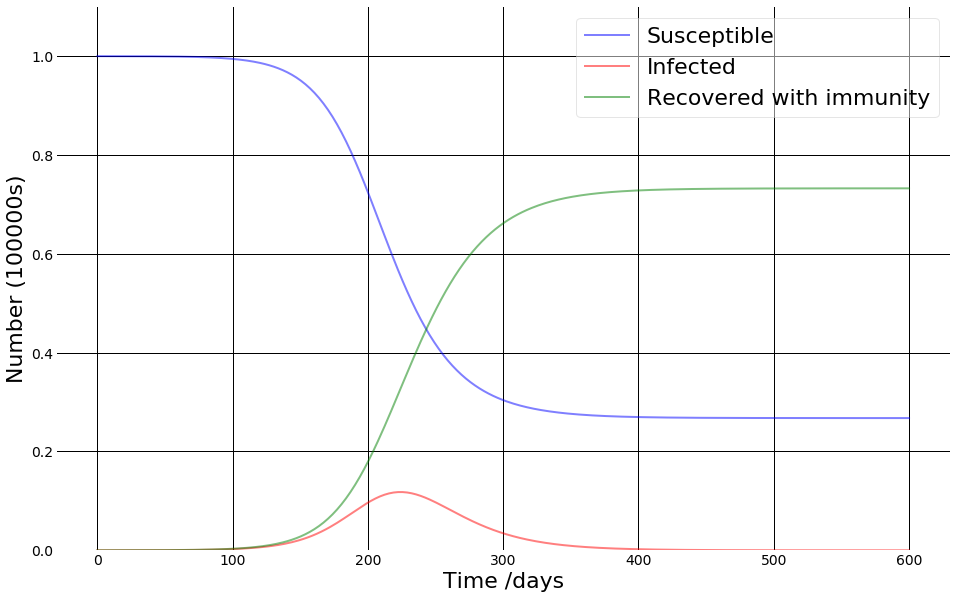

In [78]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 100000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 3, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.1, 1/18    #  https://www.worldometers.info/coronavirus/coronavirus-incubation-period/#24
# A grid of time points (in days)
t = np.linspace(0, 600, 360)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number ('+str(N)+'s)')
ax.set_ylim(0,1.1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='both',axis='both', c='black', lw=1, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

 # adapted code from:  https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

 # Reference: https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-contact-number